# PROJECT SUMMARY: WHICH DISEASES ARE COMORBID WITH OBESITY?

## Overview

This project was given to me as a data science exercise. The "who gave it to me" and "why" parts don't matter here, only the "what did they want" and the "how did they want me to do it". The goal of the project is to determine which diseases or syndromes are *comorbid* with obesity. In other words, the goal is to determine which diseases occur at higher rates in obese populations relative to non-obese populations. All of the data must come from PubMed/MEDLINE databases that are part of the National Center for Biotechnology Information (NCBI).

## Methods

Some of the methods for this project are required, and others are left for me to decide. The initial, expected workflow is as follows:

1. Retrieve the records for all papers published between 2000 and 2012 that have the term 'Obesity' as a major topic (note: 'Obesity' and 'Obesity, Morbid' are two different descriptors, but records containing either as major topics are returned using 'Obesity')
2. Using the list of all possible medical descriptors (MeSH terms), create a smaller list of terms that only refer to diseases or syndromes
3. Identify which papers talk about each disease in the new list, and extract any relevant data (number of references, odds ratio values, etc.)
4. Try to answer the question, if possible: which diseases are comorbid with obesity?

Documentation for the Entrez APIs (to access the PubMed data) can be found here:
[Entrez Documentation](https://www.ncbi.nlm.nih.gov/books/NBK25501/)

## Desired Output

The ultimate goal of the project is to determine which diseases have a higher incidence rates in obese populations relative to non-obese populations (odds ratios > 1). The goal is *NOT* to determine which diseases are more severe in obese populations. You can see an illustration of the desired output in the next section.

It's important to note that this is a **Descriptive** study, and not a **Predictive** or **Prescriptive** study. The goal here is to understand what the existing data says, not to build machine learning models or decision trees (proper ones, for actually making decisions).

## Data Limitation

One of the key assumptions that will be carried through the rest of this project is that odds ratios, statistical significances, etc. are *NOT* stored in the publication record metadata. The only place that data can be retrieved (using the approach requested) is via the abstracts. If I'm wrong, and the metadata *DOES* store that information, this project is a whole lot easier!

# SECTION 0: EXAMPLE OF WHAT WE WANT

This section below generates a synthetic dataset using Monte Carlo techniques to highlight the type of visual (and statistical) product that we want. This is just meant to be a guide so that visually-inclined readers can see the "single figure summary" that we're after.

## Setting Up the Environment

This section imports the main math and plotting libraries that we'll use throughout the project

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Defining the Function

This section creates the function that generates a synthetic dataset for our example plot

In [146]:
def create_synthetic_OR_plot():
    X_locations = [x for x in range(0,10)]
    X_labels = [chr(x+65) for x in range(0,10)]

    data = []
    centers = {}

    for location in X_locations:
        p_disease_not_obesity = np.random.random_sample() * (0.5) + 0.02
        p_disease_obesity = np.random.random_sample() * (0.5) + 0.12
        papers = int(np.random.random_sample() * (100-5) + 1)
        disease_results = []
        for i in range(0,papers):
            observations = int(np.random.random_sample() * (1000 - 100) + 100)
            bias_disease_not_obesity = np.random.random_sample() * (0.2) - 0.1
            bias_disease_obesity = np.random.random_sample() * (0.2) - 0.1
            p_eff_disease_not_obesity = p_disease_not_obesity + bias_disease_not_obesity
            p_eff_disease_obesity = p_disease_obesity + bias_disease_obesity
            p_eff_disease_not_obesity = max(0.01,min(p_eff_disease_not_obesity,0.99))
            p_eff_disease_obesity = max(0.01,min(p_eff_disease_obesity,0.99))
            samples_disease_not_obesity = np.random.binomial(1, p_eff_disease_not_obesity, observations)
            samples_disease_obesity = np.random.binomial(1, p_eff_disease_obesity, observations)
            fraction_disease_not_obesity = sum(samples_disease_not_obesity) / observations
            fraction_disease_obesity = sum(samples_disease_obesity) / observations
            if fraction_disease_not_obesity != 0:
                odds_ratio = fraction_disease_obesity / fraction_disease_not_obesity
                disease_results.append(odds_ratio)
        data.append(disease_results)
        centers[location] = np.median(disease_results)

    sorted_locs = sorted(centers, key=centers.__getitem__, reverse=True)
    data_sorted = []
    labels_sorted = []
    for i in range(0,len(X_locations)):
        data_sorted.append(data[sorted_locs[i]])
        labels_sorted.append(X_labels[sorted_locs[i]])

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1,1,1)
    ax.boxplot(data_sorted)
    ax.plot([0,11],[1,1],color="black")
    ax.set_yscale('log')
    ax.set_xticklabels(labels_sorted)
    ax.set_xlabel("Disease or Syndrome")
    ax.set_ylabel("P(Disease|Obesity) / P(Disease|NotObesity)")
    ax.set_title("Synthetic Data Showing Diseases Ranked By Median Odds Ratios", y=1.05)
    plt.show()

## Running the Function to Generate an Example Plot

Re-run this section below to see how the randomness in the function can create a range of variances!

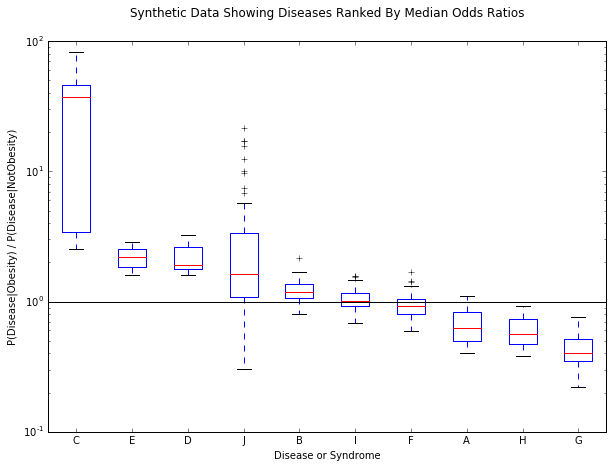

In [149]:
create_synthetic_OR_plot()

# SECTION 1: GETTING THE API DATA

This section is a one-time-use block of code meant to download the relevant data from the Entrez PubMed database and write it to a file. All future references to the data will come from the file itself, to save network bandwidth. This step is critical, though. If the wrong search terms are used, or the incorrect data is extracted and stored, the entire rest of the analysis can be compromised! The search terms used will be discussed below.

**Storage Format for Each Publication:**

PUBMED_ID  
Number  
ABSTRACT  
Abstract text  
MESH  
List of MeSH terms

## Setting Up the Environment

This section imports the necessary modules to implement the API calls. The main package used for this section is the Entrez submodule from Biopython.

In [4]:
import time
from Bio import Entrez
Entrez.email = "brianjlevay@gmail.com"

## Defining the Function

This section defines a generic function for getting PubMed records and writing the relevant data to a file. The function accepts search terms, a filename, and a keyword to determine whether to fetch the results. An initial PubMed search is performed (eSearch), and the results are stored on the server by using the 'usehistory' keyword. The search key and web environment terms are returned, and if the user opts to fetch the results, the records are downloaded in batches, 10000 at a time (using eFetch). The records are stripped down and the relevant information is stored in a local file for later access.

In [5]:
def get_api_data(terms, filename, want_fetch=False):
    handle = Entrez.esearch(db='pubmed', term=terms, usehistory='y')
    search = Entrez.read(handle)
    handle.close()

    count = int(search['Count'])
    query = search['QueryKey']
    web = search['WebEnv']
    print("{} records found through eSearch.".format(count))
    
    if want_fetch == True:
        f = open(filename + '.txt', 'w')
        
        max_ret = 10000
        steps_tot = math.ceil(count / max_ret)
        steps = [x*max_ret for x in range(0,steps_tot)]
        total_records = 0

        for step in steps:
            time.sleep(30)
            handle = Entrez.efetch(db='pubmed', query_key=query, WebEnv=web, retmode='xml', retstart=step, retmax=max_ret)
            fetch = Entrez.read(handle)
            handle.close()
            print("Step {}: API batch returned.".format(step))

            for entry in fetch:
                total_records += 1
                f.write('PUBMED_ID\n')
                f.write(entry['PubmedData']['ArticleIdList'][0] + '\n')
                f.write('ABSTRACT\n')
                try:
                    abstract = entry['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
                    if abstract == '':
                        abstract = 'No abstract available'
                    try:
                        f.write(abstract + '\n')
                    except:
                        try:
                            abstract = abstract.encode('cp1252', 'replace').decode('cp1252')
                            f.write(abstract + '\n')
                        except:
                            f.write('Abstract could not be printed.\n')
                except:
                    f.write('No abstract available.\n')
                f.write('MESH\n')
                mesh_str = ''
                for mesh in entry['MedlineCitation']['MeshHeadingList']:
                    mesh_str += mesh['DescriptorName'] + '; '
                f.write(mesh_str[0:len(mesh_str)-2] + '\n')    
                f.write('\n')

        f.close()
        print("{} records retrieved via eFetch and written to the file.".format(total_records))

## Running the Function to Gather the Data

This block of code uses the generalized function defined above to retrieve the data from PubMed. This function only needs to be run once, and afterwards, the data will be stored in a local file. 

Getting the search terms right for this exercise is critical, but an individual could likely spend days trying to understand the nuances of the descriptors / subheadings / modifiers used to retrieve data from the database. Initially, I chose to use a simple, high-level search just using 'obesity' and a date range, but this **retrieved a lot of irrelevant records**. I tried a modified search using 'obesity' with a subheading of 'morbidity', and the results appear to be more topical. However, the choices made at this step will ripple through the rest of the project, so it's important to be aware of the tradeoffs.

In [6]:
# Need to specify obesity as the major MeSH descriptor (MajorTopicYN="Y") [majr]

obesity_terms = 'obesity[majr] 2000:2012[pdat]'
obesity_morbidity_terms = 'obesity/morbidity[majr] 2000:2012[pdat]'

# Only need to run this function once to get all of the relevant API data

# get_api_data(obesity_morbidity_terms, 'obesity_pubmed', want_fetch=True)

# SECTION 2: CATEGORIZING MESH TERMS

This section uses the MeSH definitions file (desc2015.xml) to create a list of terms that refer to "Disease or Syndrome". The list will then be used to filter the MeSH terms in the publication results.

The MeSH descriptors file is large, so it will not be stored along with this code and the intermediate data products. Instead, you can download it from the following ftp site. I did not directly link the file below, because this is one you don't want to accidently start downloading with a careless click!

Location for File:  
ftp://nlmpubs.nlm.nih.gov/online/mesh/2015/

## Setting Up the Environment

This section imports BeautifulSoup, which is used for XML parsing.

In [7]:
from bs4 import BeautifulSoup

## Defining the XML Parsing Function

The source file for the MeSH terms is a large (~300 MB) xml file, and my preferred XML parser (BeautifulSoup) doesn't perform very well under such a load. So, for this exercise, I will initially split the XML file into chunks using basic string techniques, and then I will apply the parser to each fragment. This is slow, but the memory footprint is smaller and it runs without crashing. I know there are better XML libraries, but this is what I've got for now.

This function opens the definitions file, extracts only the descriptors that match a SemanticTypeName specified as an argument, and writes those terms to another file. It's important to note that this function only considers semantic types listed under the preferred concept!

In [8]:
def get_descriptors(semantic_type, filename):
    f = open('desc2015.xml', 'r')
    xml_contents = f.read()
    f.close()

    f = open(filename + '.txt', 'w')

    header_content = '<?xml version="1.0"?>\n' + '<!DOCTYPE DescriptorRecordSet SYSTEM "desc2015.dtd">\n' + \
        '<DescriptorRecordSet LanguageCode = "eng">\n' + '<DescriptorRecord DescriptorClass = "1">\n'
    xml_contents = xml_contents.replace(header_content, '')
    descriptors = xml_contents.split('</DescriptorRecord>\n<DescriptorRecord DescriptorClass = "1">')

    for descriptor in descriptors:
        descriptor = '<DescriptorRecord DescriptorClass = "1">\n' + descriptor + '</DescriptorRecord>'
        desc_soup = BeautifulSoup(descriptor, "xml")
        name = desc_soup.DescriptorName.String.get_text()
        semantic_tags = desc_soup.ConceptList.find('Concept', PreferredConceptYN='Y').find_all('SemanticTypeName')
        semantic_types = set()
        for tag in semantic_tags:
            semantic_types.add(tag.get_text())
        if semantic_type in semantic_types: 
            f.write(name + "\n")
    
    f.close()

## Running the Function to Output the Descriptors

This block of code runs the function defined above to generate a file with a list of applicable descriptors. You only need to run this once, and all future data access will come from the newly created file.

In [9]:
# Only need to run this function once to get all of the relevant terms

# get_descriptors('Disease or Syndrome', 'mesh_disease_syndrome_terms')

# SECTION 3: READING THE DATA FROM THE FILES

This section loads the data from the raw PubMed records (previously stored from the API calls) and the disease terms (previously stored from the descriptors list) into their respective data structures for use.

In [10]:
f = open('mesh_disease_syndrome_terms.txt', 'r')
disease_terms = f.read()
f.close()

disease_terms = set(disease_terms.split('\n'))
print("{} terms in the disease list.".format(len(disease_terms)))

f = open('obesity_pubmed.txt', 'r')
pubmed_raw = f.read()
f.close()

pubmed_raw = pubmed_raw.split('\n\n')
pubmed_raw = pubmed_raw[0:len(pubmed_raw)-1]
print("{} records in the raw PubMed data.".format(len(pubmed_raw)))

pubmed_records = []
for record in pubmed_raw:
    record_dict = {}
    lines = record.split('\n')
    record_dict['ID'] = lines[1]
    record_dict['ABSTRACT'] = lines[3]
    record_dict['MESH'] = lines[5].split("; ")
    pubmed_records.append(record_dict)
    
print("\nEXAMPLE RECORD\n")
for item in pubmed_records[0]:
    print("{0}: {1}".format(item,pubmed_records[0][item]))

2989 terms in the disease list.
10297 records in the raw PubMed data.

EXAMPLE RECORD

ABSTRACT: The aim is to determine the appropriate cutoff values of waist circumference (WC) for an increased risk of the metabolic syndrome in the Korean elderly population. We analyzed the WC cutoff values of four groups divided according to sex and age with a total of 2,224 elderly participants aged 65 years old and above from the Fourth Korean National Health and Nutrition Examination Survey using the receiver operating characteristic curve and multiple logistic regression. The WC cutoff values associated with an increased risk of metabolic syndrome were 89.6 cm for men and 90.5 cm for women for those who were 65 to 74 years old, and 89.9 cm for men and 87.9 cm for women for those who were 75 years old or older. WC cutoff points for estimating metabolic risk are similar in elderly men and women. Age-specific optimal WC cutoff points should be considered especially for elderly women in screening fo

# SECTION 4: COUNTING PAPERS THAT MENTION DISEASES

This section determines the number of papers that mention each disease as a MeSH keyword. It's important to note that the number of papers talking about a disease (in conjunction with obesity) actually tells us nothing about comorbidity, unless we make some strong assumptions about the *contents* of the papers. 

Papers that mention 'obesity' and disease 'A' together could be looking at:

1. The prevalence or severity of disease 'A' in obese populations
2. The prevalence or severity of obesity in populations with disease 'A'
3. The prevalence or severity of some other issue ('Complication') in populations with both disease 'A' and obesity

Even in the subset of papers that study diseases in obese populations, there are multiple explanations for why two diseases have different citation counts:

1. Disease 'A' is more common in obese populations than disease 'B', so 'A' gets more attention (what we want to know)
2. Disease 'A' is much more severe in obese populations relative to disease 'B', so 'A' gets more attention
3. The comorbidity or severity of disease 'A' in obese populations is harder to ascertain than disease 'B', and therefore more studies have been conducted to try to reduce the uncertainty
4. Disease 'A' may have more treatment options available and/or is considered easier to treat, so 'A' gets more attention
5. The research groups that study the relationships between disease 'A' and obesity might prefer breaking up their studies into smaller papers, or they might just publish more papers in general

There are almost certainly other reasons not outlined above. I'll talk about these issues more, in a bit.

## Counting the Occurrences

This section gets the number of occurrences of each disease term in MeSH keywords. It also gets the number of disease terms per paper. The algorithm works by iterating through the records, and for each record, it iterates through the MeSH term. If a term is found in the "disease_terms" list, then that term is incremented by 1 in disease_counts. In addition, each valid disease term in a record is counted, and the total number of valid terms per record is stored in the diseases_per_paper dictionary.

In [11]:
disease_counts = {}
diseases_per_paper = {}

start_time = time.time()
for record in pubmed_records:
    term_ct = 0
    for term in record['MESH']:
        if term in disease_terms:
            if term in disease_counts:
                disease_counts[term] += 1
            else:
                disease_counts[term] = 1
            term_ct += 1
    if term_ct in diseases_per_paper:
        diseases_per_paper[term_ct] += 1
    else:
        diseases_per_paper[term_ct] = 1
end_time = time.time()

print("Time for algorithm: {} seconds\n".format(round(end_time - start_time),2))

Time for algorithm: 0 seconds



## Looking at the Raw Data

This section makes some general observations about the results.

In [12]:
import pandas as pd

disease_cts_df = pd.DataFrame.from_dict(disease_counts, orient='index')
disease_cts_df.reset_index(inplace=True)
disease_cts_df.columns = ['Disease','Cts']
disease_cts_df.sort_values('Cts', ascending=False, inplace=True)
disease_cts_df

,Disease,Cts
76,Cardiovascular Diseases,787
261,Hypertension,770
26,"Diabetes Mellitus, Type 2",617
157,Metabolic Syndrome X,574
160,Diabetes Mellitus,457
19,Chronic Disease,226
332,Pregnancy Complications,172
118,Asthma,142
225,Dyslipidemias,127
410,Hyperlipidemias,126


In [13]:
pct_zero = 100*diseases_per_paper[0]/len(pubmed_records)
pct_one = 100*diseases_per_paper[1]/len(pubmed_records)
pct_more = 100 - pct_one - pct_zero

more_than_one_df = disease_cts_df.loc[disease_cts_df['Cts'] > 1]
more_than_five_df = disease_cts_df.loc[disease_cts_df['Cts'] > 5]
more_than_ten_df = disease_cts_df.loc[disease_cts_df['Cts'] > 10]
more_than_twenty_df = disease_cts_df.loc[disease_cts_df['Cts'] > 20]
more_than_hundred_df = disease_cts_df.loc[disease_cts_df['Cts'] > 100]
more_than_twohund_df = disease_cts_df.loc[disease_cts_df['Cts'] > 200]

total_mentions = disease_cts_df['Cts'].sum()
papers_with_one_or_more = len(pubmed_raw) - diseases_per_paper[0]

print("Number of Disease Terms Per Paper")
print(diseases_per_paper, "\n")
print("Percentage of Papers With No Disease Terms in MeSH Keywords: {0:.2f} %".format(pct_zero))
print("Percentage of Papers With One Disease Term in MeSH Keywords: {0:.2f} %".format(pct_one))
print("Percentage of Papers With Two or More Disease Terms in MeSH Keywords: {0:.2f} %\n".format(pct_more))

print("Number of diseases or syndromes with >   0 mentions: {}".format(len(disease_cts_df)))
print("Number of diseases or syndromes with >   1 mentions: {}".format(len(more_than_one_df)))
print("Number of diseases or syndromes with >   5 mentions: {}".format(len(more_than_five_df)))
print("Number of diseases or syndromes with >  10 mentions: {}".format(len(more_than_ten_df)))
print("Number of diseases or syndromes with >  20 mentions: {}".format(len(more_than_twenty_df)))
print("Number of diseases or syndromes with > 100 mentions: {}".format(len(more_than_hundred_df)))
print("Number of diseases or syndromes with > 200 mentions: {}\n".format(len(more_than_twohund_df)))

print("Total number of times disease or syndrome terms were mentioned: {}".format(total_mentions))
print("Total number of papers with at least one disease or syndrome term: {}".format(papers_with_one_or_more))

Number of Disease Terms Per Paper
{0: 6164, 1: 2376, 2: 940, 3: 481, 4: 214, 5: 84, 6: 20, 7: 12, 8: 2, 9: 2, 10: 2} 

Percentage of Papers With No Disease Terms in MeSH Keywords: 59.86 %
Percentage of Papers With One Disease Term in MeSH Keywords: 23.07 %
Percentage of Papers With Two or More Disease Terms in MeSH Keywords: 17.06 %

Number of diseases or syndromes with >   0 mentions: 468
Number of diseases or syndromes with >   1 mentions: 267
Number of diseases or syndromes with >   5 mentions: 123
Number of diseases or syndromes with >  10 mentions: 71
Number of diseases or syndromes with >  20 mentions: 46
Number of diseases or syndromes with > 100 mentions: 11
Number of diseases or syndromes with > 200 mentions: 6

Total number of times disease or syndrome terms were mentioned: 7233
Total number of papers with at least one disease or syndrome term: 4133


## Plotting the Data

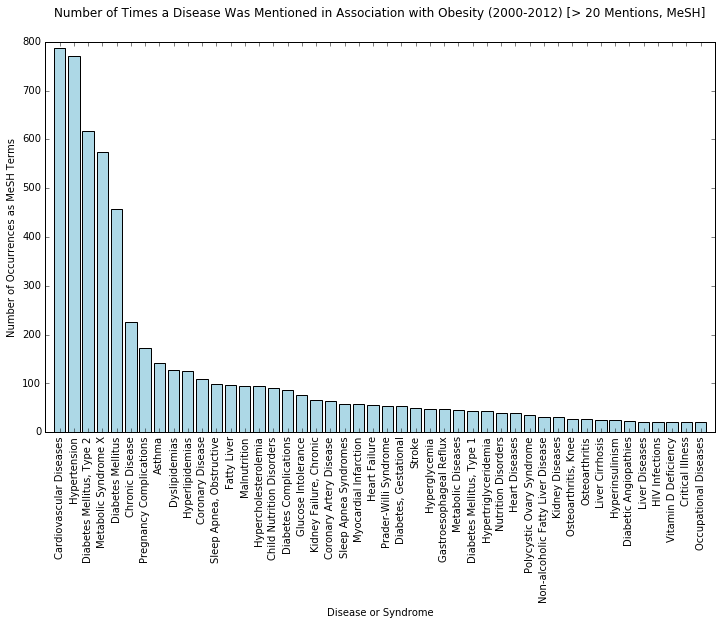

In [141]:
df_to_plot = more_than_twenty_df
cutoff = 20

max_X = len(df_to_plot)
X_vals = [x for x in range(0,max_X)]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
ax.bar(X_vals,df_to_plot['Cts'],align='center',color='lightblue')
ax.set_xticks(X_vals)
ax.set_xticklabels(df_to_plot['Disease'], rotation=90)
ax.set_xlim([-1,max_X])
ax.set_xlabel('Disease or Syndrome')
ax.set_ylabel('Number of Occurrences as MeSH Terms')
ax.set_title('Number of Times a Disease Was Mentioned in Association with Obesity (2000-2012) [> '+str(cutoff)+' Mentions, MeSH]', y=1.05)
plt.show()

## Discussion

First, it's worth noting that the majority of the PubMed records that we retrieved (~60 %) don't discuss any diseases or syndromes in association with obesity. Approximately 23 % of the records contain only one associated disease or syndrome keyword, and the rest contain two or more. Two records even contain 10 disease keywords in its MeSH terms!

Second, it's worth noting that, although there were 468 different diseases or syndromes mentioned at least once, only 123 were mentioned more than 5 times. You can see if the figure above (only showing terms mentioned > 20 times) that there is a long tail, with a large number of diseases only discussed (alongside obesity) in a relatively small number of papers.

So, which diseases are discussed most often alongside obesity? 

1. Cardiovascular Diseases
2. Hypertension
3. Diabetes Mellitus, Type 2
4. Metabolic Syndrome X
5. Diabetes Mellitus

It's pretty clear that many of the disease / syndrome terms are related in nature. If I had more of a medical background (and understood the diseases better), I'd group similar conditions to better understand the classes of problems being studied.

So, what can we make of this data? As discussed at the beginning of this section, more studies (or more papers) do not necessarily mean higher incidence rates in obese populations! First, we have to consider that many papers talking about 'obesity' and 'disease A' aren't necessarily looking at the *relationship* between the two. They are looking at some third factor in populations with both 'obesity' and 'disease A'. Second, even if the studies are *about* the relationship between 'obesity' and 'disease A', we don't know whether the studies were looking at the odds of the disease in obese people or the odds of obesity in diseased people. Third, citation counts don't really tell us about odds ratios. It could be that the diseases with more attention are more prevalent (what we want), more severe, more treatable, more ambiguous (unclear odds ratios), etc. The only way to truly determine which of these diseases are comorbid (odds ratios > 1) is to extract the data from the records themselves.

# SECTION 5: EXTRACTING DATA FROM ABSTRACTS

Finding the number of papers that mention a disease (in conjunction with obesity) only gets us so far towards answering our question. The pitfalls were discussed extensively in the previous section, so they won't be repeated here. What we really need to know is what the papers actually **say** about the disease in relation to obesity, and in particular, what we want to know is the **odds ratios** for the diseases in obese vs non-obese populations.

It's possible that a more refined PubMed search could eliminate many of the irrelevant records and return more epidemiology-oriented papers, making our job easier. As specified in the introduction, I'm carrying the assumption that the statistical results of the papers are not recorded in the metadata. If I am wrong (possible!), then the nature of this project changes quite a bit. However, for now, we're going to try to work with our very unconstrained dataset.

First, we'll take a closer look at some samples of the data, and then we'll try a few brute-force methods for gathering data. Text processing, in the best of scenarios (well-structured data), is challenging. In a scenario such as this (free-form text, no expectation of common language terms or writing styles), given the limited time, it may be impossible. If this was a more substantial project, the two areas that would need more focus would be: refining the initial search, and building out a decent set of text search algorithms.

## Looking at a Sample of Abstracts

In this section, we'll print a few records for the most commonly cited term. It's worth a good, qualitative look at the data to get a feel for how different authors might or might not summarize the relevant data in the abstracts.

In [15]:
disease_sought = disease_cts_df['Disease'].iloc[0]
max_records = 5

print("A sample of records with the term '{}':\n".format(disease_sought))

returned_records = 0
for record in pubmed_records:
    for term in record['MESH']:
        if term == disease_sought:
            print('ABSTRACT')
            print(record['ABSTRACT'], "\n")
            print('MESH')
            print(record['MESH'], "\n")
            print('------------------------------------------------------\n')
            returned_records += 1
            break
    if returned_records == max_records:
        break

A sample of records with the term 'Cardiovascular Diseases':

ABSTRACT
Waist circumference (WC) is a useful measure for identifying children at higher risk of complications related with abdominal fat. We determined the magnitude of central adiposity, single and combined with overweight and obesity in infants 1-5 years old. We also identified smoothed age-and sex-specific WC percentile values, which were compared with other countries available data. This was a cross-sectional study in children of 8 day care centers located in Monterrey, Mexico (n = 903, 431 boys and 472 girls). Because the risk due to abdominal obesity begins at WC percentile > or = 75, we considered two thresholds, percentile 75 y 90. Overweight was defined based on body mass index at percentile 85-94 for age and sex; and obesity, at percentile > or = 95. Analysis consisted of point prevalence and 95% confidence intervals. The LMS Chart Maker Light software was used for smoothing WC percentile values. The study populat

## Regex Tests

This is just a section for me to test out regex for finding odds ratio terms. Getting these terms correct is challenging. As you can see in some of the abstract samples shown above, there are lots of papers reporting "> or = ##", which means we're restricted to using capital "OR". Glancing through abstracts on my own, it does appear that "OR" is the standard abbreviation, so we're not likely missing too many papers leaving out "or = ".

In [122]:
import re

tests = ['My dog has an OR = 2.61.', \
         'My dog has an O.R. = 800.', \
         'My dog has an or=2.9.', \
         'My dog has an OR=2.9.', \
         'My dog has a p = 7.8.', \
         'My dog has an ore = 0.', \
         'My dog has a tor.= 1200', \
         'My dog has > or = 12 treats', \
         'My dog has an OR 262', \
         'My dog has an [OR] = 12.2', \
         'My dog has an [O.R.] = 19', \
         'My dog has an [O.R. = 124]', \
         'My dog has an (OR = 14)',\
         'My dog is THOR = 12']

reg_main = r'(?:\[|\b|\()O.?R[\.\]\)=\s]+(?:\d*\.)?\d+'

print("Testing the Main Regex Term:")
for test in tests:
    search = re.findall(reg_main,test)
    print(search)

tests_2 = ['My odds ratio is 2.4.', \
           'My Odds Ratio is 12.', \
           'My Odds ratio = 14.8.', \
           'My odds ratio of 42']

reg_alt = r'[oO]dds [rR]atio (?:=|is|of) (?:\d*\.)?\d+'

print("\nTesting the Alternative Regex Term:")
for test in tests_2:
    search = re.findall(reg_alt,test)
    print(search)

Testing the Main Regex Term:
['OR = 2.61']
['O.R. = 800']
[]
['OR=2.9']
[]
[]
[]
[]
['OR 262']
['[OR] = 12.2']
['[O.R.] = 19']
['[O.R. = 124']
['(OR = 14']
[]

Testing the Alternative Regex Term:
['odds ratio is 2.4']
['Odds Ratio is 12']
['Odds ratio = 14.8']
['odds ratio of 42']


## Attempting to Get Values from the Text

In this section, we'll attempt to get some of the desired odds ratios out of the abstracts. The approach that we'll use here is a very simple one, using regex searchs with a few key expressions. We'll almost certainly miss reported odds ratios using this technique. In addition, we won't be able to distinguish P(Disease|Obesity) from P(Obesity|Disease), and we won't be able to know which disease corresponds to which odds ratio if multiple are reported in a study. Language processing is complicated, and in a real study, this section would require the bulk of the allocated time.

In [123]:
study_results = []
start_time = time.time()
for record in pubmed_records:
    study_diseases = []
    study_values = []
    has_or_terms = False
    for mesh_term in record['MESH']:
        if mesh_term in disease_terms:
            study_diseases.append(mesh_term)
    if len(study_diseases) > 0:
        text = record['ABSTRACT'].replace('~','')
        regex_terms = [reg_main, reg_alt]
        for reg in regex_terms:
            search_results = re.findall(reg,text)
            if len(search_results) > 0:
                study_values += search_results
        if len(study_values) > 0:
            study_results.append([record['ID'],study_diseases, study_values])
end_time = time.time()

print("Total Number of Records Found with OR Values: {}\n".format(len(study_results)))
print("Examples of Results:\n")
for i in range(0,30):
    print(study_results[i][0], " ", study_results[i][1], " ", study_results[i][2])

Total Number of Records Found with OR Values: 64

Examples of Results:

23312304   ['Pediatric Obesity']   ['OR = 1.74']
23201911   ['Pediatric Obesity']   ['(OR=1.47', '(OR=1.339']
23109638   ['Intervertebral Disc Displacement', 'Polyradiculopathy']   ['(OR) 1.17', 'OR 1.06', '(OR 0.9']
23077856   ['Metabolic Syndrome X']   ['(OR 6.97', '(OR 6.74', '(OR 21.64']
23077855   ['Metabolic Syndrome X']   ['(OR 1.033', '(OR 1.143', '(OR 6.189']
23000799   ['Cardiovascular Diseases', 'Diabetes Mellitus', 'Hypercholesterolemia', 'Hypertension']   ['[OR] = 1.44', '(OR = 1.84', '(OR = 1.45', '(OR = 1.87', '(OR = 2.83', '(OR = 2.44']
22936705   ['Pneumonia']   ['(OR 0.96', '(OR 0.86', '(OR 1.40']
22833658   ['Metabolic Syndrome X']   ['[OR = 0.48', '[OR = 0.28', 'OR = 0.52', 'OR = 0.34']
22806540   ['Migraine Disorders']   ['[OR 2.10']
22653771   ['Asthma']   ['(OR 1.96', '(OR 1.84', '(OR 1.46']
22619058   ['Asymptomatic Diseases', 'Cerebral Small Vessel Diseases', 'Nervous System Diseases']   ['

## Validating the Results

In this section, we'll pull the abstracts for a few records and compare them to the results obtained above. If the odds ratios that we scraped appear to be in-context and match the type of data we're looking for, we might have some more confidence in our methods.

In [124]:
i_vals = [0,5,6]

for record in pubmed_records:
    for val in i_vals:
        if record['ID'] == study_results[val][0]:
            print('ABSTRACT\n')
            print(record['ABSTRACT'], "\n")
            print('DATA COLLECTED\n')
            print('Diseases:  ', study_results[val][1])
            print('OR Values: ', study_results[val][2])
            print('------------------------------------------------------\n')
    

ABSTRACT

Childhood obesity is an increasing public health problem, particularly among minority infants and young children. Disparities in overweight prevalence persist and widen with age, highlighting the need to identify factors contributing to early excess weight gain. We review the behavioral, social and macro-environmental factors contributing to the development of obesogenic early feeding practices among African-American infants and young children. We then examine the sociodemographic, household factors, feeding beliefs and infant characteristics associated with age-inappropriate feeding of liquids and solids (inappropriate feeding) among mothers and infants participating the U.S. Infant Care and Risk of Obesity Study, a cohort study of 217 low-income, first-time mothers and infants followed from 3 to 18 months of age. Maternal and infant anthropometry, infant diet, and maternal and household characteristics were collected at home visits at 3, 6, 9, 12 and 18 months of age. Mixed

## Refining the Results

As you can see from the search results above, our data is still pretty messy. First, we only found a relatively small number of papers that reported odds ratios in a way that allows us to retrieve them. We almost certainly left data behind! However, earlier, more inclusive searches returned a lot of junk that wasn't related to odds ratios. Another problem is that many of the papers contain multiple disease terms and multiple odds ratios. It will be impossible for me to process the text (in this time window) in such a way that I can assign OR values to different diseases. So, for now, I have to discard all such records. 

That leaves only records that have one disease term. However, even in a single paper with a single disease term, there can be multple odds ratios published (see above). How do we know what each term is referring to? How do we even know that *any* of the terms refer to P(Disease|Obesity) / P(Disease|NotObesity)? We **don't**!

Regardless, if we have OR values from multiple papers, we might be able to make *some* inferences. We'll discuss this further in a bit.

In [131]:
single_study_results = {}

for study in study_results:
    values = []
    if len(study[1]) == 1:
        for odds_ratio in study[2]:
            odds_value = re.findall(r'(?:\d*\.)?\d+', odds_ratio)
            values += odds_value
        values_float = [float(x) for x in values]
        if study[1][0] in single_study_results:
            single_study_results[study[1][0]] += values_float
        else:
            single_study_results[study[1][0]] = values_float
            
print("Total number of diseases with OR values: {0}\n".format(len(single_study_results)))
for disease in single_study_results:
    print(disease, ": ", single_study_results[disease])

Total number of diseases with OR values: 24

Coronary Disease :  [1.87]
Diabetes Mellitus, Type 2 :  [1.08, 0.99]
Asthma :  [1.96, 1.84, 1.46, 1.93, 0.75, 1.02, 0.94, 5.8]
Osteoarthritis :  [8.1, 5.9, 0.7, 1.1]
Diabetic Retinopathy :  [2.02, 1.48, 0.66, 0.72]
Cataract :  [1.31, 1.6, 1.33, 1.3]
Myocardial Infarction :  [0.81, 0.56]
Bone Diseases, Developmental :  [1.27]
Hyperinsulinism :  [5.7, 7.0, 1.7]
Coronary Artery Disease :  [2.4, 2.5, 6.0, 2.6, 3.8, 7.8, 6.5]
Hypertension :  [2.45, 6.72, 6.76, 1.64, 0.61, 1.5, 1.53, 0.74, 0.66, 3.49, 3.55]
Migraine Disorders :  [2.1]
Pregnancy Complications :  [3.1, 4.1, 2.2, 24.7, 2.1, 8.1, 3.4, 2.2, 2.14, 2.29, 3.33, 1.1, 1.2, 25.0, 3.0, 1.0, 1.3, 0.8, 1.3, 1.4]
Lymphedema :  [2.93]
Metabolic Syndrome X :  [6.97, 6.74, 21.64, 1.033, 1.143, 6.189, 0.48, 0.28, 0.52, 0.34, 1.66, 1.42, 1.6, 38.354, 1.043, 0.696, 0.61, 1.53, 0.68, 0.69, 0.43]
Gastrointestinal Diseases :  [2.65, 1.89, 1.45, 1.74, 1.76, 1.33, 1.32]
Diabetes Mellitus :  [2.91, 1.84, 1.

## Plotting the Data

Caution! The plot below is merely showing the odds ratios taken from papers where only one disease term is present in the MeSH keywords. The odds ratios have no context, and many (most?) do NOT refer to the desired odds ratio: P(Disease|Obesity) / P(Disease|NotObesity).

**DO NOT USE THIS FIGURE TO MAKE ANY SIGNIFICANT CONCLUSIONS**

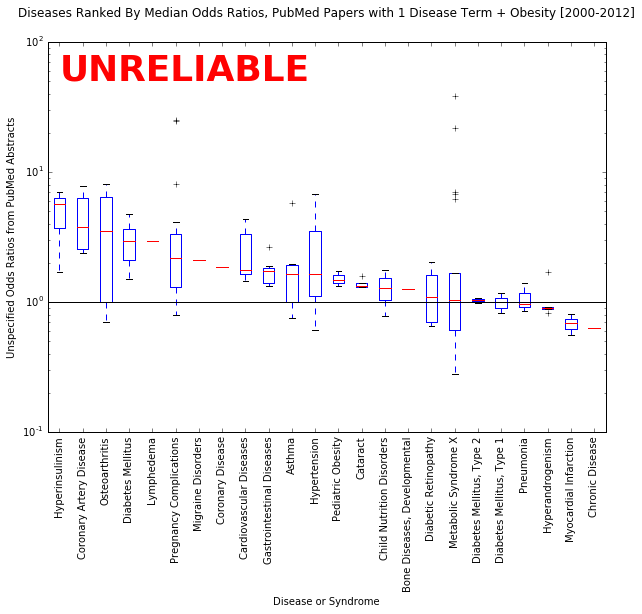

In [162]:
summary_diseases = {}
for study in single_study_results:
    summary_diseases[study] = np.median(single_study_results[study])

sorted_diseases = sorted(summary_diseases, key=summary_diseases.__getitem__, reverse=True)
data_sorted = []
labels_sorted = []
for i in range(0,len(summary_diseases)):
    data_sorted.append(single_study_results[sorted_diseases[i]])
    labels_sorted.append(sorted_diseases[i])

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax.boxplot(data_sorted)
ax.plot([0,len(summary_diseases)+1],[1,1],color="black")
ax.set_yscale('log')
ax.set_xticklabels(labels_sorted, rotation=90)
ax.set_xlabel("Disease or Syndrome")
ax.set_ylabel("Unspecified Odds Ratios from PubMed Abstracts")
ax.set_title("Diseases Ranked By Median Odds Ratios, PubMed Papers with 1 Disease Term + Obesity [2000-2012]", y = 1.05)
plt.text(1, 50, 'UNRELIABLE', fontsize=36, color="red", weight="bold")
plt.show()

## Discussion

Content goes here...

# CONCLUSIONS

Content goes here...